# Nutritional Analysis
This Notebook analyses data exported from myfitness pal. Before the analysis the data needs to be joined and cleaned

## Checking the working directory
The current working directory is printed for informational purposes and to help with debugging any problems with the relative paths used to load the myfitnesspal files.

In [17]:
import os
cwd = os.getcwd()
print(cwd)

C:\Users\kenne\code\kennyrnwilson\git\health\analysis


## Process myfitnesspal files
The following function reads in two files that have been exported from myfitnesspal. 

 * Weight
 * Calories, macro and micro nutrients
 
 Since myfitness pal exports meal data and I am only interested in per day numbers the meals in each day need to be aggregated

In [19]:
import pandas as pd

def generate_df_from_myfitnesspal_files(weights_file, nutrition_file):

    # Read in the csv of weights and the csv of nutritional data
    weight_df = pd.read_csv(weights_file, index_col = 'Date')
    all_nutrition_df = pd.read_csv(nutrition_file)
    
    # We are only interested in the calories and macro-nutrient amounts in grams
    detailed_macros = all_nutrition_df[['Date','Calories','Fat (g)','Carbohydrates (g)','Protein (g)']]
    
    # The detailed_macros dataframe has a row per meal. The following logic groups and aggregates so we have 
    # one row per day
    aggregation_functions = {'Calories': 'sum', 'Fat (g)': 'sum', 'Protein (g)': 'sum', 'Carbohydrates (g)': 'sum'}
    aggregated_macros = detailed_macros.groupby('Date').aggregate(aggregation_functions)
    
    # I want to know the total calories from each macro
    fat_cals = aggregated_macros['Fat (g)'] * 9
    prot_cals = aggregated_macros['Protein (g)'] * 4
    carb_cals = aggregated_macros['Carbohydrates (g)'] * 4
    
    # Now get the percentages 
    fat_percent = fat_cals / aggregated_macros['Calories']
    prot_percent = prot_cals / aggregated_macros['Calories']
    carb_percent = carb_cals / aggregated_macros['Calories']
    fat_percent.name = 'Fat(%)'
    carb_percent.name = 'Carb(%)'
    prot_percent.name = 'Prot(%)'
    
    # Add the weight and nutritional data into one dataframe
    final_data = pd.concat([weight_df['Weight'],aggregated_macros[['Calories','Protein (g)','Fat (g)','Carbohydrates (g)']], prot_percent, fat_percent, carb_percent], axis=1)

    # Sort the data
    final_data.sort_index(inplace=True)
    
    # Back fill and forward fill missing data
    final_data.bfill(inplace=True)
    final_data.ffill(inplace=True)
    
    return final_data


## Use the function to generate a dataframe

In [20]:
all_fitness_data = generate_df_from_myfitnesspal_files('..\data\my-fitness-pal\weight.csv',
                                                       '..\data\my-fitness-pal\macro-micro.csv')

all_fitness_data

,Weight,Calories,Protein (g),Fat (g),Carbohydrates (g),Prot(%),Fat(%),Carb(%)
Date,,,,,,,,
2023-03-05,73.0,440.1,41.4,15.5,33.9,0.376278,0.316973,0.308112
2023-03-06,68.0,1795.8,124.2,62.4,150.5,0.276646,0.312730,0.335227
2023-03-07,68.0,1622.2,175.6,43.7,122.2,0.432992,0.242449,0.301319
2023-03-08,68.0,1508.5,92.5,48.2,178.3,0.245277,0.287570,0.472788
2023-03-09,68.0,1989.8,202.8,24.3,185.1,0.407679,0.109911,0.372098
...,...,...,...,...,...,...,...,...
2023-05-21,68.2,2254.2,155.8,48.9,216.9,0.276462,0.195236,0.384882
2023-05-22,68.2,2689.2,176.3,97.1,278.1,0.262234,0.324967,0.413655
2023-05-23,68.5,2561.0,165.5,88.8,257.5,0.258493,0.312066,0.402187


## Calculate Maintenance Calorie Statistics
We create a function to take 14 days of data from the dataframe generates in the previous section and 
generate a single row with estimated maintenance calories. 

In [12]:
def calc_maint_stats(last_fourteen):
    # Now we separate the foureen rows into week one and week two
    week_one = last_fourteen.head(7)
    week_two = last_fourteen.tail(7)

    # Calculate the mean weight on each week
    week_one_mean_wgt = week_one['Weight'].mean()
    week_two_mean_wgt = week_two['Weight'].mean()

    # Take the diffence of the two weeks as the average weight change per week
    weekly_mean_wgt_change = week_two_mean_wgt - week_one_mean_wgt

    # Convert weekly weight change in kilograms to weekly weight change in calories
    weekly_mean_wgt_cals = weekly_mean_wgt_change * 3500

    # Convert weekly weight change in caloreies to weekly daily weight change in calories
    calorie_surplus = weekly_mean_wgt_cals / 7

    # Calculate the average calorie consumption over the fourteen days
    cals_mean = last_fourteen['Calories'].mean()

    # Calculate estimated base calorie level
    maint = cals_mean - calorie_surplus
    
    row = pd.DataFrame([{'wgt_week_a_mean':week_one_mean_wgt,
                         "wgt_week_b_mean":week_two_mean_wgt,
                         "wgt_week_mean_change":weekly_mean_wgt_change,
                         "wgt_week_mean_change_cal":weekly_mean_wgt_cals,
                         "daily_maint_cal":maint,
                         "daily_cal_mean": cals_mean,
                         "daily_cal_surplus":calorie_surplus,
                         }], index=[last_fourteen.index[13]])
    
    return row

In [13]:
row = calc_maint_stats(final_data.tail(14))
row

,wgt_week_a_mean,wgt_week_b_mean,wgt_week_mean_change,wgt_week_mean_change_cal,daily_maint_cal,daily_cal_mean,daily_cal_surplus
2023-05-25,67.842857,68.2,0.357143,1250.0,2378.821429,2557.392857,178.571429


In [21]:
summary = pd.DataFrame()
num_rows = len(final_data.index)
print(num_rows)
for x in range(14, num_rows+1):
    row = calc_maint_stats(final_data.iloc[x-14:x])
    summary = pd.concat([summary,row])

summary

82


,wgt_week_a_mean,wgt_week_b_mean,wgt_week_mean_change,wgt_week_mean_change_cal,daily_maint_cal,daily_cal_mean,daily_cal_surplus
2023-03-18,68.714286,68.000000,-0.714286,-2500.0,1953.135714,1595.992857,-357.142857
2023-03-19,68.000000,68.000000,0.000000,0.0,1681.385714,1681.385714,0.000000
2023-03-20,68.000000,68.000000,0.000000,0.0,1645.742857,1645.742857,0.000000
2023-03-21,68.000000,68.000000,0.000000,0.0,1640.278571,1640.278571,0.000000
2023-03-22,68.000000,68.000000,0.000000,0.0,1661.414286,1661.414286,0.000000
...,...,...,...,...,...,...,...
2023-05-21,67.942857,67.871429,-0.071429,-250.0,2558.235714,2522.521429,-35.714286
2023-05-22,67.871429,68.000000,0.128571,450.0,2460.142857,2524.428571,64.285714
2023-05-23,67.885714,68.071429,0.185714,650.0,2442.778571,2535.635714,92.857143
2023-05-24,67.857143,68.100000,0.242857,850.0,2436.657143,2558.085714,121.428571


# Analysis
## Calorie Consumption


<AxesSubplot:>

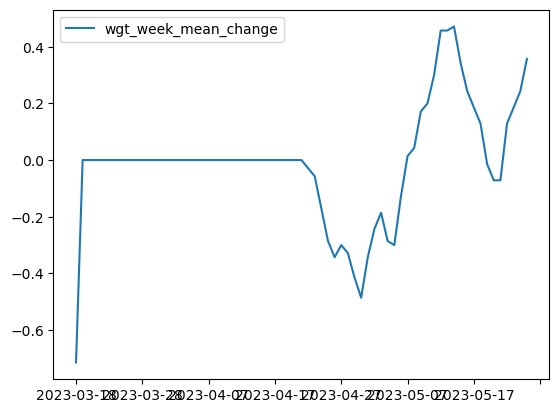

In [16]:
import matplotlib as mpl
import matplotlib.pyplot as plt

summary.plot(y="wgt_week_mean_change")